# Importing

In [ ]:
import numpy as np
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn')

# GMM Creation

In [ ]:
class Gaussian:
    def __init__(self, mu=None, sigma=None) -> None:
        '2D Gaussian pdf'
        D = 2
        self.mu = mu if mu is not None else  10 * (np.random.random(D) - 0.5)
        self.sigma = sigma if sigma is not None else 0.05*(np.eye(2) + 0.1*np.random.random((2,2)))
        self.sigma = (self.sigma + self.sigma.T)/2   # to make it symmetric
        self.sigmainv = np.linalg.inv(self.sigma)
        self.Z = 2*np.pi*np.sqrt(np.linalg.det(self.sigma))
    def sample(self, S=1):
        'return SxD np array'
        return np.random.multivariate_normal(self.mu, self.sigma, size=S)
    def prob(self, x_s):
        'x_s is SxD; returns an np array of len S'
        retval = []
        for x_mu in (x_s-self.mu):
             retval.append(np.exp(-0.5*(x_mu).T @ (self.sigmainv) @ (x_mu))/self.Z)
        return np.array(retval)
        
class GMM:
    def __init__(self, N=5) -> None:
        'GMM with N Gaussian components'
        self.components = [Gaussian() for _ in range(N)] 
        self.weights = np.random.random(N)
        self.weights /= np.sum(self.weights)
    def sample(self, S=1):
        #print(self.weights)
        retval = []
        count_z = np.random.multinomial(S, self.weights)
        #print(count_z)
        for z, count in enumerate(count_z):
            retval.append(self.components[z].sample(S=count))
        return np.vstack(retval)
    def prob(self, x_s):
        retval = []
        p = np.zeros(len(x_s))
        for z, w in enumerate(self.weights):
            p += w * self.components[z].prob(x_s)
        return p
    
    def gs_components(self):
      return self.components

def plot_samples_2d(data, filename=None):
    'data is SxD'
    plt.figure(figsize=(5,5))
    plt.scatter(data[:, 0], data[:, 1]) 
    if filename:
        plt.savefig('./%s'%(filename) + ".png", format="png")

In [ ]:
gmm= GMM()
gs = gmm.gs_components()

### Plot 0: True Samples from the GMM

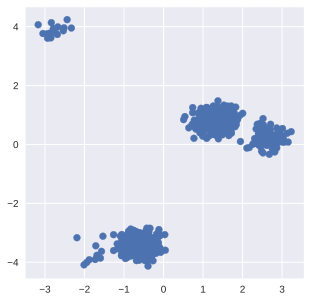

In [ ]:
plot_samples_2d(gmm.sample(1000))

# VAE Training

In [ ]:
batch_size = 128
latent_dim = 2
epochs = 30

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
def build_encoder(dim):

    input_layer = layers.Input((dim,))
    X = input_layer
    for i in range(4):
        X = layers.Dense(16)(X)
        X = layers.LeakyReLU(0.1)(X)
    #output_layer = layers.Dense(output_dim)(X)

    z_mean = Dense(latent_dim, name='z_mean')(X)
    z_log_var = Dense(latent_dim, name='z_log_var')(X)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    encoder = Model(input_layer, [z_mean, z_log_var, z], name = "encoder")
    return encoder

In [ ]:
encoder = build_encoder(2)

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 16)           48          ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 16)           272         ['leaky_re_lu[0][0]']            
                                                                                            

In [ ]:
def build_decoder(output_dim):

    input_layer = layers.Input((latent_dim,))
    X = input_layer
    for i in range(4):
        X = layers.Dense(16)(X)
        X = layers.LeakyReLU(0.1)(X)
    output_layer = layers.Dense(output_dim)(X)
    
    decoder = Model(input_layer, output_layer, name = "decoder")
    return decoder

In [ ]:
decoder = build_decoder(2)

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_4 (Dense)             (None, 16)                48        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                272       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16)                0   

In [ ]:
def loss_total(z_log_var, z_mean, inputs, outputs):

  kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

  mse = K.sum(K.square(inputs - outputs), axis = -1)

  vae_loss = K.mean(mse + kl_loss)
  return vae_loss

In [ ]:
def VAE(dim, decoder, encoder):
  input_layer = layers.Input((dim,))
  [z_mean, z_log_var, z] = encoder(input_layer)
  output_layer = decoder(z)
  
  vae = Model(input_layer, output_layer)

  
  vae.add_loss(loss_total(z_log_var, z_mean, input_layer, output_layer))
  vae.compile(optimizer = 'adam')
  return vae

In [ ]:
vae = VAE(2, decoder, encoder)

In [ ]:
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          932         ['input_3[0][0]']                
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 2)            898         ['encoder[0][2]']                
                                                                                              

In [ ]:
NUM_BATCHES = 2000
BATCH_SIZE = 512

In [ ]:
vae_losses = []
vae_accs = []

for step in range(NUM_BATCHES):
  print(f'1b: {step}/{NUM_BATCHES}', end='\r')
  # Train discriminator
  vae.trainable = True
  inputs = gmm.sample(BATCH_SIZE // 2)
  _vae_loss = vae.train_on_batch(inputs)

  vae_losses.append(_vae_loss)
  print(_vae_loss)
  # vae_accs.append(_vae_accuracy)

7.129997253417969
7.073416233062744
6.840108871459961
6.6164350509643555
6.694744110107422
6.810500144958496
6.366826057434082
6.689046859741211
6.618654251098633
6.930100440979004
6.393117904663086
6.988190650939941
6.304133415222168
6.126374244689941
6.068761825561523
6.717860221862793
6.489457607269287
6.232800483703613
6.2353363037109375
5.811407566070557
5.396313190460205
5.850432395935059
5.353844165802002
5.566323280334473
5.5808258056640625
5.377941131591797
5.21230411529541
5.246426582336426
4.647548675537109
5.3223066329956055
5.337841510772705
4.615415573120117
4.619814872741699
4.469499588012695
4.6428375244140625
4.288392066955566
4.177087783813477
4.359403610229492
4.163841247558594
4.239421844482422
4.1936116218566895
4.3891377449035645
4.293511867523193
4.073753356933594
4.023301124572754
4.201291561126709
4.447792053222656
4.052717208862305
3.9497287273406982
4.165778160095215
3.902719497680664
4.180845737457275
3.714576482772827
3.441011905670166
3.8754358291625977
3.

# Q2 . Testing the VAE by checking its ability to re-construct the points sampled from original GMM i.e. $p_x^*$.   
### Quantitatively this can be seen as calculating MSE Loss between the original and re-constructed points.

In [ ]:
# def generate_noise(samples, dimensions=2):
#     '''
#     Generate a matrix of random noise in [-1, 1] with shape (samples, dimensions) 
#     '''
#     return np.random.uniform(-100, 100, (samples, dimensions))

In [ ]:
# def uniform_to_normal(z):
#     '''
#     Map a value from ~U(-1, 1) to ~N(0, 1)
#     '''
#     norm = stats.norm(0, 1)
#     return norm.ppf((z+1)/2)

In [ ]:
# test_noise = generate_noise(1000, 2)

In [ ]:
[z_mean, z_log_var, z] = encoder(gmm.sample(1000))
outputs = decoder(z)

***The outputs of the Decoder Plotted Below are the re-constructed samples of the GMM samples***
The MSE loss calculated on these re-constructed samples can be used as a metric to define the performance of model.

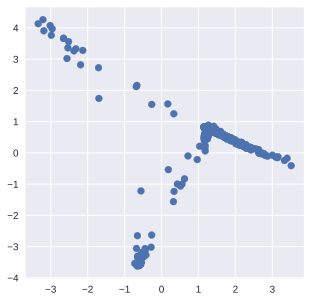

In [ ]:
plot_samples_2d(outputs)

# Q5 and Q2. Visualizing the Latent Space of VAE



In [ ]:
def vae_points(inputs):
  [z_mean, z_log_var, z] = encoder(inputs)
  outputs = decoder(z)
  return z, outputs

In [ ]:
z_all, _ = vae_points(gs[0].sample(200))
labels_all = tf.cast(0*tf.ones(z_all.shape[0]), dtype = tf.int32)

1. Below I sample 200 samples from each Gaussian Component of the GMM.
2. Then attach labels to this samples. Label is the index of the Gaussian component to which the sample belongs.
3. Then I calculate **z_mean($\mu$) and z_log_var($log(\sigma)$)** for each of the samples. Then sample a new z(latent vector) from $N(\mu, \sigma)$.
4. Plot these latent vectors in the 2D plane and color them according to the label attached to them.

In [ ]:
for i in range(1, len(gs)):
  samples = gs[i].sample(200)
  # gs_samples.append(samples)
  z, _ = vae_points(samples)
  labels = tf.cast(i*tf.ones(z.shape[0]), dtype = tf.int32)
  #print(labels)

  z_all = tf.concat([z_all, z], axis = 0)
  labels_all = tf.concat([labels_all, labels], axis = 0)
  #print(labels_all)

### Plot 1: Q5. Visualizing the latent space

***Each colour represents the samples belonging to different Gaussian Components of the GMM.***  
We can clearly see that samples belonging to a particular Gaussian component are clustered together.

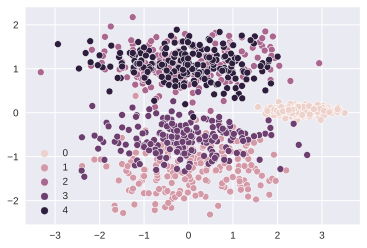

In [ ]:
import seaborn as sns
sns.scatterplot(x=z_all[:, 0], y=z_all[:, 1], hue=labels_all)

## Observation Related to Q5
As it is clearly visible from the above graph that samples from the same Gaussian component in the observed space, are also clustered toghether in the latent space. Hence each Gaussian component of $p_x^*$, does correspond to a specific region in the latent space, in case of VAE.

## Q4. Illustration of one of the Pros of VAE over GAN

### Sampling new points from some particular Gaussian component of $p_x^*$, when we have one sample from that particular component, but no info about the Gaussian component itself.
1. This is not possible to do with GAN, as in there we couldn't relate latent space to observed space directly.

Sampling a point from gmm,which can belong to any of the 5 components of the GMM. We don't know the component to which this observation sample belongs. 

In [ ]:
test_sample = gmm.sample(1)

Finding $\mu$ and $\sigma$ in latent space for this component.

In [ ]:
[z_mean, z_log_var, z] = encoder(test_sample)
# outputs = decoder(z)

In [ ]:
new_points = z

Sampling 200 new latent vectors from $N(\mu, \sigma)$ that we calculated above. All of these new latent vectors belong roughly to the same component in the latent space and hence the correspoding observations samples will also belong to the same Gaussian from GMM.

In [ ]:
for i in range(200):
  z = Lambda(sampling, output_shape=(2,), name='z')([z_mean, z_log_var])
  new_points = tf.concat([new_points, z], axis = 0)

### Plot 2

Latent vectors

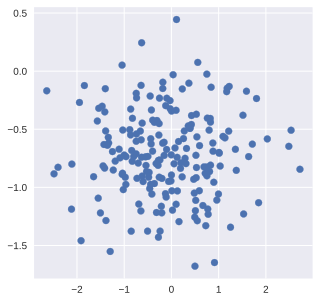

In [ ]:
plot_samples_2d(new_points)

##### The plot 2 for latent space roughly corresponds to the component labelled with color corresponding to component 2 in Plot 1 for latent space.  
Hence we sampled 200 new points from the component 2 in Plot 1, using the same $\mu_\phi$ and $\sigma_\phi$, that we obtained for one point from component 2.

### Plot 3

Decoded samples in the observation space, which belong to the same Guassian from the GMM. We can compare the below plot to the plot of samples from the GMM, to confirm whether any such component exists in the observation space/GMM.

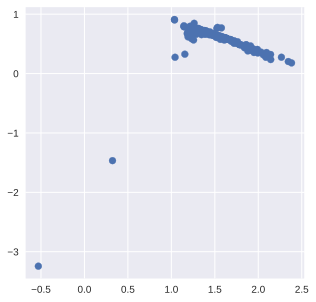

In [ ]:
plot_samples_2d(decoder(new_points))

#### Observing the x and y co-ordinates carefully one can easily come to conclusion that the points correspond to the bottom-most Gaussian component in Plot 0, which is the observed sample space

# Q2.Evaluating VAE using Log-Likelihood of re-constructed points

I didn't run this code segment due to shortage of time. So the results under this heading are not correct. Please re-run these below 6 cells, to get the correct results.

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
probs = gmm.prob(decoder(new_points))

In [1]:
print(probs.shape, new_samples.shape)

In [ ]:
log_likelihood = 0
for p in probs:
  log_likelihood += tf.math.log(p)

In [ ]:
# print(probs)

In [2]:
log_likelihood

# Q1 and Q2 . Generating new samples from VAE by sampling the latent vectors from N(0, I)

Here the dimension of I in N(0, I) will be 2 cause the latent space is 2d

In [ ]:
gaussian_2d = tfp.distributions.MultivariateNormalDiag(
    loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
)

In [ ]:
new_latent_vectors = gaussian_2d.sample(1000)
new_samples = decoder(new_latent_vectors)

### Q1. Plot of New Samples from VAE

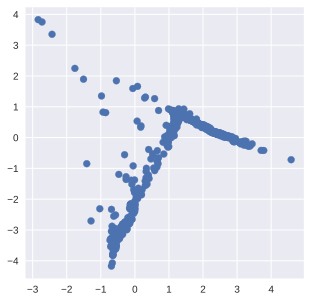

In [ ]:
plot_samples_2d(new_samples)

# Q2. Evaluating VAE using Log-Likelihood of generated points

Why not just likelihood in place of log-likelihood?  

1. Log-likelihood ensures numerical stability.   
2. Using just likelihood might result in the likelihood being approximated to zero because of large number of multiplications of values which are less than 1

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [ ]:
probs = gmm.prob(new_samples)

In [ ]:
print(probs.shape, new_samples.shape)

(1000,) (1000, 2)


In [ ]:
log_likelihood = 0
for p in probs:
  log_likelihood += tf.math.log(p)

In [ ]:
# print(probs)

In [ ]:
log_likelihood

<tf.Tensor: shape=(), dtype=float64, numpy=-3310.637684061731>

# Intuitive Argument as to no meaning can be derived from latent space of GAN to do any meaningful task 


2. As here we are sampling a point from latent space, feeding into the generator and then treating that output as some new point which is a part of the inherent p_star, can we really track back in the latent space? 

3. -- given any new point sampled from the one of the gaussian component of the GMM(which has 5 gaussian component), how can we find the latent vector in z space corresponding to this point? At this point it seems like the latent space itself has no meaning as we cannot connect any observed state to it. --- Hence this is one of the major limitations of GAN.
4. In case of VAE, we get the latent state from an observed state, hence it is possible to connect the location of latent state in latent space to the observed states.

5. Another limitation of GAN:----
Lets say we generated a 2d point(x1, y1) in space by giving a latent vector z sampled from latent space to the Generator.
Now lets say we want to generate another point, which is very close to this 2d point that we generated earlier. 

Now due to the limitation that we don't have any intuitive correspondance between the points in the 2d space and the latent space of Generator, we won't be able to find a 'z' by some calculation which can give us a point which is close to the point that we generated earlier(x1, y1).

In case of VAE, we record the $\mu_\phi$ and $\sigma_\phi$ for (x1, y1), then to generate a new point near (x1, y1) we keep $\mu_\phi$ and $\sigma_\phi$ same, and sample a new z such that $z \sim N(\mu_\phi, \sigma_\phi)$, and then decode this new latent vector using the trained decoder. This would give a new point close to (x1, y1).

We can also control the approximate distance of this new point from (x1, y1). If we increase the value of $\sigma_\phi$, we the newly sampled $z$ can lie far away from the $\mu_\phi$, and hence the resulting output obtained through the decoder would also be farther away.

Extending this concept to application of GAN to generate new faces, lets say we generated a male face with no moustache. Then if want to generate a new male face with little moustache, then we don't have any method to find the correct latent vector, other than just hit and trail so find the correct vector.

So this way, if we want to change some


6. Path tracing in case of VAEs
Lets say that we have a 2d latent space.

7. Generating a mixture of features using vector addition in VAE.

# VAE with One-Dimensional Latent Space

In [ ]:
latent_dim = 1

In [ ]:
decoder_1d = build_decoder(2)

In [ ]:
decoder_1d.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense_18 (Dense)            (None, 16)                32        
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_19 (Dense)            (None, 16)                272       
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16)                0         
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 16)                0   

In [ ]:
encoder_1d = build_encoder(2)

In [ ]:
# encoder_1d.summary()

In [ ]:
vae_1d = VAE(2, decoder_1d, encoder_1d)

In [ ]:
# vae_1d.summary()

In [ ]:
vae_losses = []
vae_accs = []

for step in range(NUM_BATCHES):
  print(f'1b: {step}/{NUM_BATCHES}', end='\r')
  # Train discriminator
  vae.trainable = True
  inputs = gmm.sample(BATCH_SIZE // 2)
  _vae_loss = vae.train_on_batch(inputs)

  vae_losses.append(_vae_loss)
  #print(_vae_loss)
  # vae_accs.append(_vae_accuracy)

2.7283225059509277
2.695713520050049
3.4252724647521973
2.765045166015625
2.808198928833008
2.8309197425842285
2.669576644897461
2.6520164012908936
2.615034580230713
2.688284397125244
2.721621036529541
2.8166565895080566
2.7074508666992188
2.748514175415039
2.9079699516296387
2.7410361766815186
2.6886162757873535
2.7817392349243164
2.8190975189208984
2.771206855773926
2.790724754333496
2.7871575355529785
2.758622646331787
2.7161145210266113
2.778292655944824
2.5310888290405273
2.595669746398926
2.549591541290283
2.7034528255462646
2.590608596801758
2.645090103149414
2.818437099456787
2.5872249603271484
2.679717540740967
2.929028272628784
2.8464407920837402
2.7122302055358887
2.59767484664917
3.1319539546966553
2.6473827362060547
2.7234058380126953
2.6620264053344727
2.708609104156494
2.764692783355713
2.737617015838623
2.788255214691162
2.79549503326416
2.578963279724121
2.689209222793579
2.825982093811035
2.855484962463379
2.780324935913086
2.868399143218994
2.562962770462036
2.842417

In [ ]:
def vae_points(inputs, encoder, decoder):
  [z_mean, z_log_var, z] = encoder(inputs)
  outputs = decoder(z)
  return z, outputs

In [ ]:
z_all, _ = vae_points(gs[0].sample(20), encoder_1d, decoder_1d)
labels_all = tf.cast(0*tf.ones(z_all.shape[0]), dtype = tf.int32)

In [ ]:
# print(z_all.shape, labels_all.shape)

In [ ]:
for i in range(1, len(gs)):
  samples = gs[i].sample(20)
  # gs_samples.append(samples)
  z, _ = vae_points(samples, encoder_1d, decoder_1d)
  labels = tf.cast(i*tf.ones(z.shape[0]), dtype = tf.int32)
  #print(labels)

  z_all = tf.concat([z_all, z], axis = 0)
  labels_all = tf.concat([labels_all, labels], axis = 0)
  #print(labels_all)

In [ ]:
# print(z_all.shape, labels_all.shape)

In [ ]:
# print(z_all[:, 0].shape)

In [ ]:
# labels_all

In [ ]:
# print(z_all)

## Plot 4

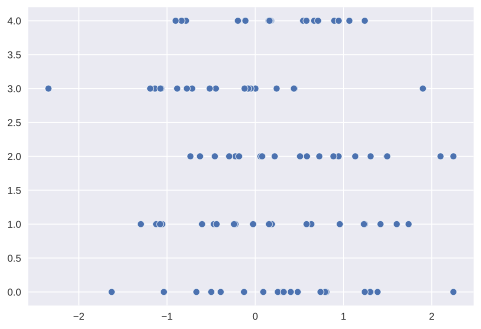

In [ ]:
import seaborn as sns
sns.scatterplot(x=z_all[:, 0], y = labels_all)

### Observation:
The numbers on the y-axis represent the components.  

One can easily observe that the points in the latent space for each of the component, don't seem to be clustered together around some point, so we could not draw some inference regarding the clustering of points from the same component of $p_x^*$ in the latent space.

This thing is also reflected in the plotting of samples in the observed states(see plot 5), when these latent vectors are passed to the decoder network. The reconstruction is not good at all, meaning that the compression didn't carry sufficient information in the latent space.  
Hence I conclude from these experiments that 1d latent space is not enough here to contain all the compressed information such that it can be re-constructed.

In [ ]:
test_noise = generate_noise(1000, 2)##uniform_to_normal(generate_noise(1000, 2))

In [ ]:
[z_mean, z_log_var, z] = encoder_1d(gmm.sample(1000))
outputs = decoder_1d(z)

In [ ]:
# print(outputs)

## Plot 5

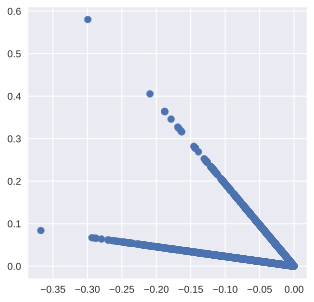

In [ ]:
plot_samples_2d(outputs)

## Observations:
1. It seems like the the 1d latent space here is not able to re-construct the points sampled from GMM. The reason might be that the 2d info can't be compressed into 1d.
2. Can this result obtained is because of some error in loss function or it might be a result of overfitting of data.

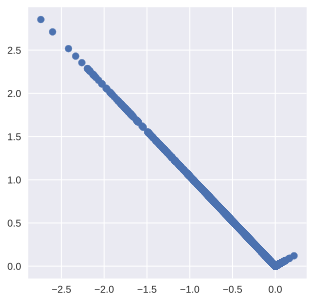

In [ ]:
[z_mean, z_log_var, z] = encoder_1d(test_noise)
outputs = decoder_1d(z)
plot_samples_2d(outputs)

construct a VAE without KL loss and try to show the discountinuity that might arise because of it.

1. make a custom GMM which has Gaussians which are placed far apart(such that they don't cross each other).
2. then train one model without kl loss, second one without the MSE loss and other with both the losses. show the difference.

### Ideas for testing the VAE other than just re-constructing the points fed to the encoder

1. feed a point sampled from some specific component of GMM. Record the $\mu_\phi$ and $\sigma_\phi$ for this point.
2. Now keeping the $\mu_\phi$ fixed, sample some new points in latent space for $\sigma_\phi$. Decode them using decoder and plot. Do this for the other componenets also, and see if the resulting plot looks similar to the plot obtained by sampling from the original GMM.

3. As we are using the info of only 5 points from the observed space and the rest of the points are generated from the sampling done in the latent space, this could prove that our VAE has really trained well on the GMM.